
### Project Overview

Betting is massive domain and there plenty of companies looking to make predictions based on football data since a good prediction allows you to price bets. I believe that most of the companies are doing a good job predicting results since they make a lot of money from bets.

This project will be based in [https://www.kaggle.com/hugomathien/soccer] data, is data about 25.000 scores and 10.000 players, using this data will try to predict the outcome of the match. If we consider the amount of data and the quality of the data we should be able to predict results based on the squads and the stats.

I like football and this could be my first iteration on this data, and later on, I could search for other prediction like the which is the most important player per squad, which are the best odds based on the prediction, check if the odds are right based on the predictions.

I've found a few articles where some people try to predict results of sports games like [An Artificial Neural Network
Approach to College Football
Prediction and Rankings][3] and [Using Machine Learning to Predict the
Outcome of English
County twenty over Cricket Matches][4] which are final projects.

### Problem Statement

I want to use the historical match data to predict more recent match results.
The problem is supervised learning problem, where the labels are the different possible results of the match and the possible features are the players and their skill level.


The skill level of the players is based on the FIFA skill set, those are relevant because they get updated quite often on the relation with the player's performance.
The result of the match is going to be a classification problem since we will try to know how will win or if there is going to be a draw.


### Data Exploration


This is very unbalaced model where most os the labels are home wins, on over 21000+ matches 11917 are home wins.



In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

%autoreload 2

import explore_dataset 
import numpy as np
import sqlite3
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


labels counts 
home    11917
away     7466
draw     6596
dtype: int64


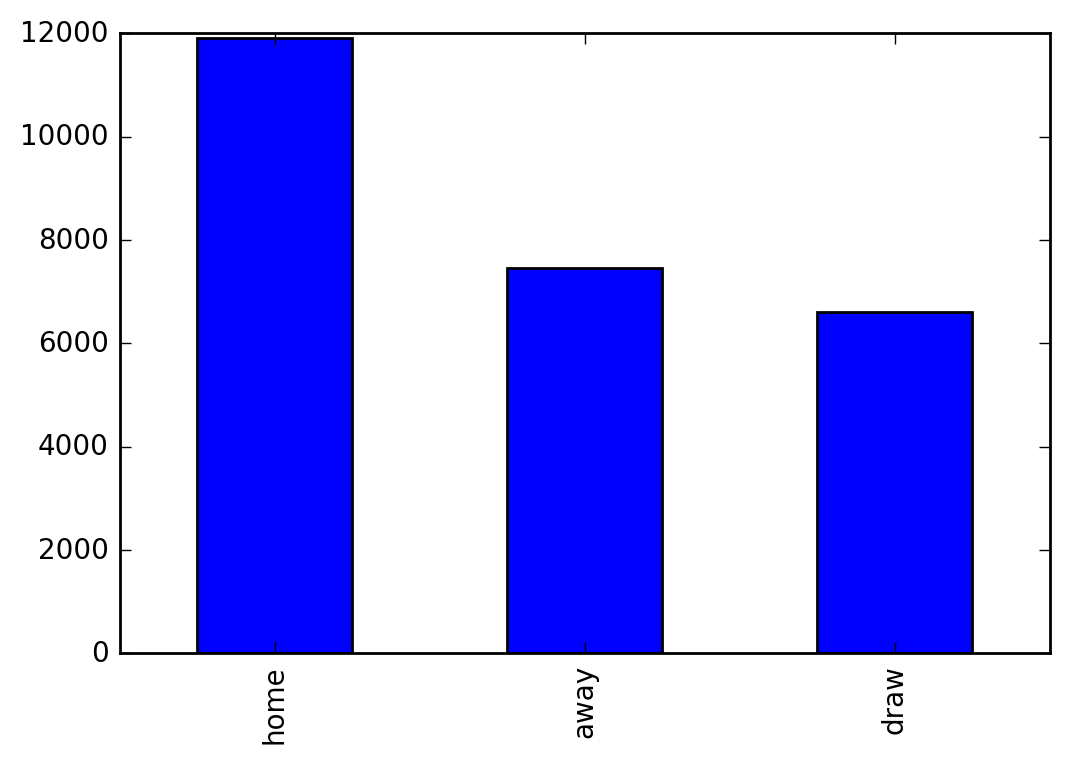

In [2]:
con = sqlite3.connect('./data/database.sqlite')

df = pd.read_sql_query("SELECT * FROM Match m", con)

labels = df.apply(explore_dataset.calculate_label, axis=1)

print "labels counts \n",labels.value_counts()

labels.value_counts().plot.bar()

Another factor are the "strong" teams that have a good percentage of victories

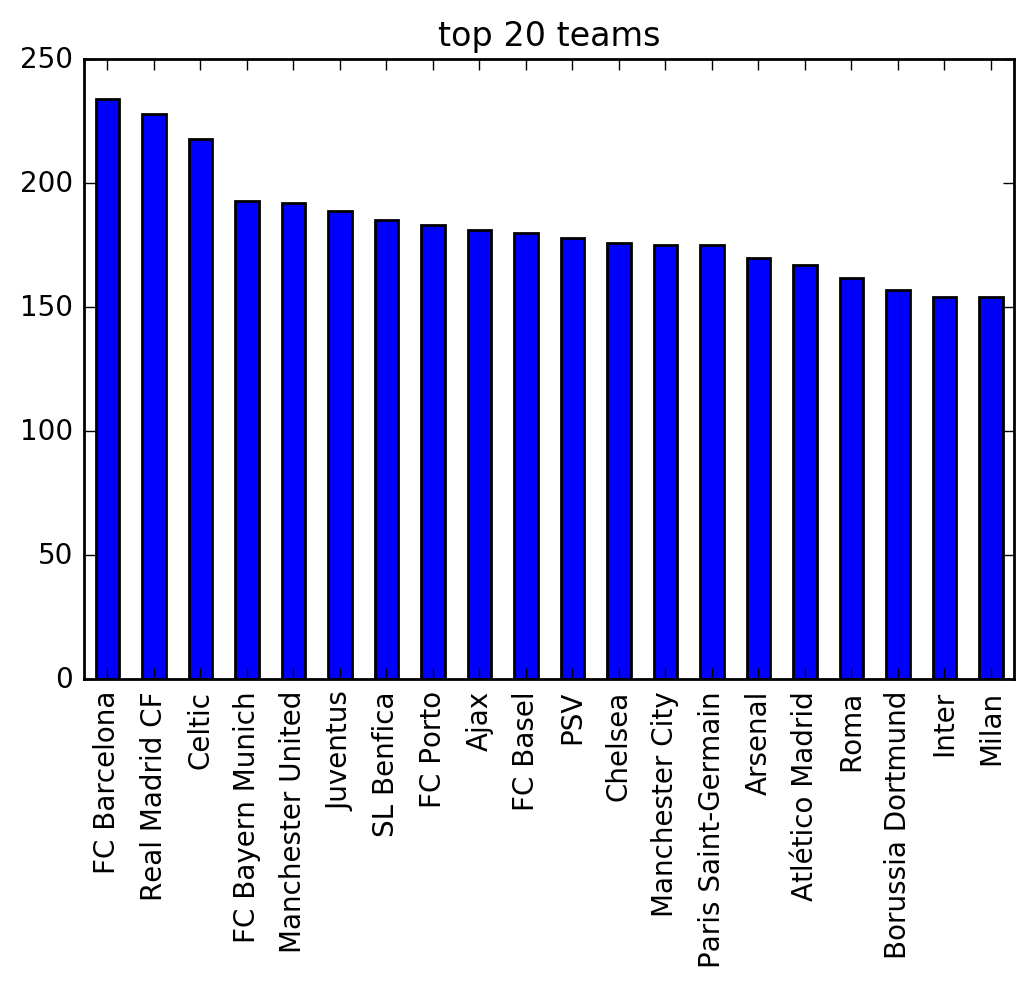

In [3]:
teams = pd.read_sql_query("SELECT * FROM Team", con)

winners = labels.to_frame(name='winner')
home_winners_index =  winners[winners['winner'] == 'home'].index
away_winners_index =  winners[winners['winner'] == 'away'].index

winner_teams = df.iloc[home_winners_index]['home_team_api_id'].squeeze().append( df.iloc[away_winners_index]['away_team_api_id'].squeeze())
winner_teams_names = winner_teams.apply(lambda id: teams.loc[teams['team_api_id'] == id]['team_long_name'].values[0])

winner_teams_names.value_counts().head(20).plot.bar(title='top 20 teams')

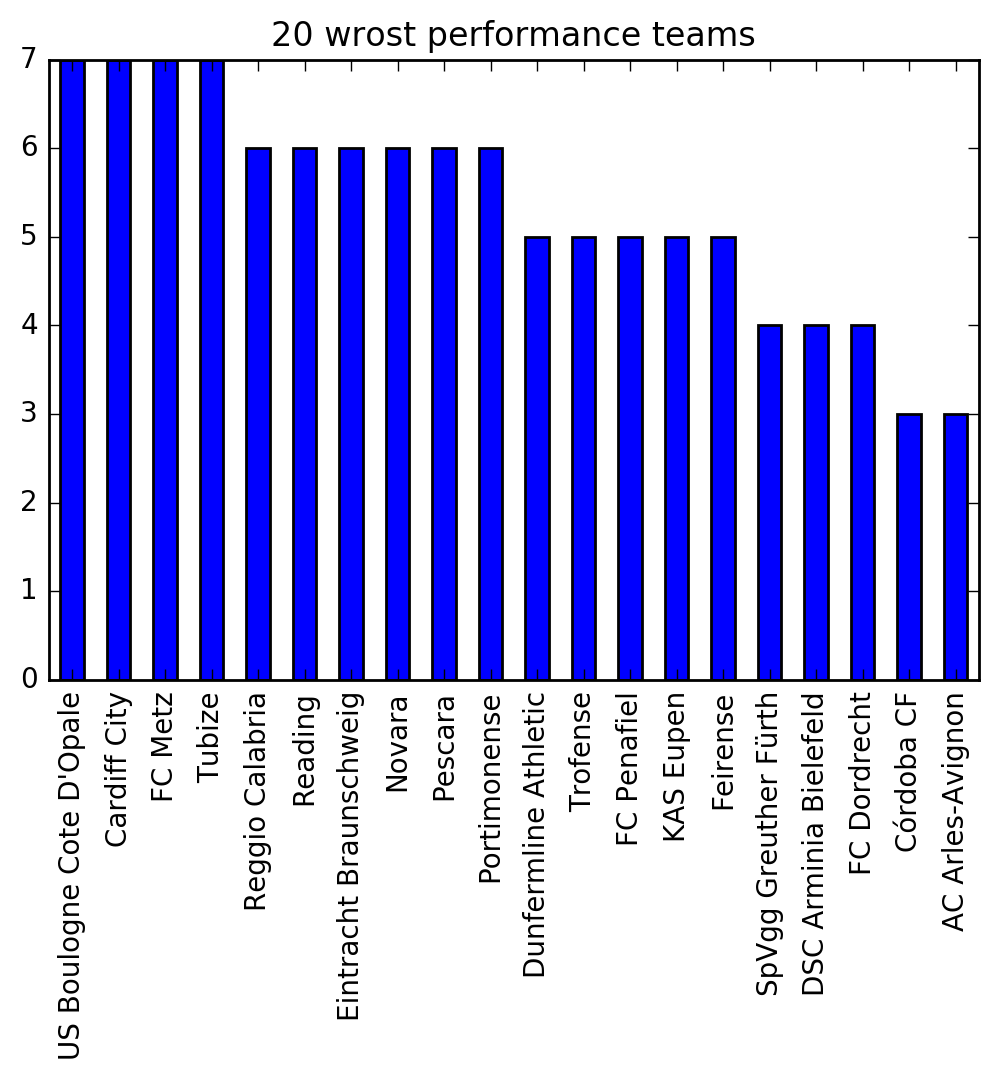

In [4]:
winner_teams_names.value_counts().tail(20).plot.bar(title= '20 wrost performance teams')

### Data Prepocessing

In order to have  clear data that we could process we have know which metrics do we have before the match and how they could be relevant to our algorithms.



#### Calculate stats by match

In [6]:
from funcy import join

stat_columns = join(map(lambda stat: explore_dataset.create_stats_columns(df, stat),
                        explore_dataset._STATS_COLUMNS_))

matches = df.assign(**stat_columns)
""" created a dict with the matches played per team and the stats on the match"""
stats_by_team_dict = dict([(team_id, explore_dataset.extract_stats_by_team_id(matches, team_id)) 
                           for team_id in teams['team_api_id']])

Using the stats_by_team_dict we can extract the stats of the n-matches before any date. 



In [23]:
from datetime import datetime
print explore_dataset.extract_n_previous_matches(stats_by_team_dict, 9906, datetime(2016, 5, 14))

            team_api_id  shoton  shotoff  cross  foulcommit  corner
date                                                               
2016-05-08         9906       6        9     24          11       5
2016-04-20         9906       2        6     11           6       4
2016-04-09         9906       4        8     16          14       5
2016-03-19         9906       1        4      9          11       2
2016-03-06         9906       5       12     17           9       7


### Now lets check the players stats

In [141]:
players = pd.read_sql_query("SELECT * FROM Player_Attributes p_a JOIN Player p on p.player_api_id = p_a.player_api_id ", con)
players = players.loc[:,~players.columns.duplicated()]
print players[["overall_rating", "player_name"]].drop_duplicates(subset='player_name').sort_values(by="overall_rating",ascending=False).head(10)
print players[["overall_rating"]].describe()

        overall_rating         player_name
102482            94.0        Lionel Messi
33330             93.0   Cristiano Ronaldo
105983            90.0         Luis Suarez
109033            90.0        Manuel Neuer
131464            90.0              Neymar
183672            89.0  Zlatan Ibrahimovic
16460             89.0        Arjen Robben
122441            88.0         Mesut Oezil
12773             88.0      Andres Iniesta
47247             88.0         Eden Hazard
       overall_rating
count   183142.000000
mean        68.600015
std          7.041139
min         33.000000
25%         64.000000
50%         69.000000
75%         73.000000
max         94.000000


The players Attributes has 23 features which is not acceptable considering that every match has 11 players per team, that will make around 506 features per match.
In order to reduce the dimmensionality to avoid getting a dimensionality problem and overfitting.

In [331]:
from sklearn.decomposition import PCA
# Important players stats
__PLAYER_STATS__ = ["overall_rating", "potential",
                         "crossing", "finishing", "heading_accuracy", "short_passing", "volleys", "dribbling", "curve",
                         "free_kick_accuracy", "long_passing", "ball_control", "acceleration", "sprint_speed",
                         "agility", "reactions", "balance", "shot_power", "jumping", "stamina", "strength",
                         "long_shots", "aggression"]

players_stats = players.drop_duplicates(subset='player_api_id').set_index("player_api_id")[__PLAYER_STATS__]
players_stats = players_stats.fillna(value=0)  # clean rows with NAN as data

print players_stats.shape

pca = PCA(n_components=0.6)
principal_components = pca.fit_transform(players_stats )
print pca_fitted.explained_variance_ratio_
print principal_components.shape
stats = pd.DataFrame(principal_components, index=players_stats.index,columns=["pc_stats_0","pc_stats_1"])
#players_stats.assign(pc_0=principal_components[:,0],pc_1=principal_components[:,1])

(11060, 23)
[ 0.58246786  0.10923561]
(11060, 2)


After Applying PCA, We can observe that we can reduce dimmensionality to 2 features keeping 68% of the variance.



Let's start to create the features to use in our model:

1. add the players features.

In [360]:
_STARTING_FEAURES_ =  ['home_team_api_id','away_team_api_id','date','home_team_goal','away_team_goal','home_player_1',
          'home_player_2','home_player_3','home_player_4',
          'home_player_5','home_player_6','home_player_7',
          'home_player_8','home_player_9','home_player_10',
          'home_player_11','away_player_1','away_player_2',
          'away_player_3','away_player_4','away_player_5',
          'away_player_6','away_player_7','away_player_8',
          'away_player_9','away_player_10','away_player_11']

# lets remove the non important features and remove the ones that is missing any features
complete_matches= df[_STARTING_FEAURES_].dropna(how='any')

players=['home_player_1',
          'home_player_2','home_player_3','home_player_4',
          'home_player_5','home_player_6','home_player_7',
          'home_player_8','home_player_9','home_player_10',
          'home_player_11','away_player_1','away_player_2',
          'away_player_3','away_player_4','away_player_5',
          'away_player_6','away_player_7','away_player_8',
          'away_player_9','away_player_10','away_player_11']
# add the features that we have calculated previously


def add_player_stats(data, player):
    return pd.merge(complete_matches, stats, left_on=[player], right_index=True)\
    .rename(columns={'pc_stats_0': player+'_0', 'pc_stats_1':player+'_1'})\
    .drop(player, axis=1)
    

matches_with_players = reduce(add_player_stats, players, complete_matches)
matches_with_players.head(10)



,home_team_api_id,away_team_api_id,date,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,...,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11_0,away_player_11_1
145,8203,9987,2009-02-27 00:00:00,2,1,38327.0,67950.0,67958.0,67959.0,37112.0,...,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,-69.862482,0.444431
410,9993,9984,2010-01-17 00:00:00,1,4,13131.0,37988.0,36849.0,38322.0,38800.0,...,38789.0,38186.0,104386.0,27110.0,37051.0,166670.0,38357.0,38251.0,-69.862482,0.444431
530,8203,9987,2010-10-01 00:00:00,2,2,39573.0,67950.0,39389.0,80184.0,67941.0,...,38293.0,104411.0,148314.0,39498.0,43158.0,127191.0,169200.0,42153.0,-69.862482,0.444431
562,10001,9987,2010-11-05 00:00:00,1,1,38341.0,43049.0,21834.0,37953.0,38339.0,...,38293.0,104411.0,148314.0,32863.0,39498.0,43158.0,127191.0,42153.0,-69.862482,0.444431
576,9986,9987,2010-11-20 00:00:00,1,3,104388.0,45469.0,166684.0,46666.0,208688.0,...,43158.0,94462.0,148314.0,32863.0,42153.0,39498.0,104411.0,38794.0,-69.862482,0.444431
633,9994,9987,2010-12-30 00:00:00,2,2,30934.0,25465.0,95609.0,94030.0,166675.0,...,38293.0,43158.0,148314.0,39498.0,104411.0,169200.0,42153.0,38794.0,-69.862482,0.444431
647,10000,9987,2011-01-28 00:00:00,0,1,37900.0,37100.0,131532.0,46877.0,131404.0,...,94462.0,148314.0,43158.0,39498.0,104411.0,169200.0,38794.0,42153.0,-69.862482,0.444431
707,9984,9987,2011-03-20 00:00:00,0,1,36835.0,38342.0,27110.0,38789.0,191787.0,...,43158.0,94462.0,148314.0,42153.0,38368.0,39498.0,169200.0,38794.0,-69.862482,0.444431
724,8342,9987,2010-09-12 00:00:00,2,2,37990.0,36832.0,27508.0,42594.0,47411.0,...,38293.0,43158.0,148314.0,32863.0,39498.0,104411.0,169200.0,38794.0,-69.862482,0.444431
742,9997,9987,2010-09-21 00:00:00,0,2,38962.0,38347.0,3329.0,149150.0,40768.0,...,38293.0,43158.0,148314.0,39498.0,104411.0,127191.0,169200.0,38794.0,-69.862482,0.444431


2. lets add the teams previous stats features.

In [408]:
print df.head(1).columns
#matches_with_players\
#.apply(partial(explore_dataset.extract_stats_by_match,stats_by_team_dict),axis=1,raw=True)

Index([u'id', u'country_id', u'league_id', u'season', u'stage', u'date',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal',
       ...
       u'SJA', u'VCH', u'VCD', u'VCA', u'GBH', u'GBD', u'GBA', u'BSH', u'BSD',
       u'BSA'],
      dtype='object', length=115)
